In [1]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
import tensorflow as tf
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import tensorflow_probability as tfp
from tensorflow.keras import layers
import sklearn

In [2]:
cd ../../icme-xplore-bayes-spring22/src/data

/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


## Data Preprocessing

In [3]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/np.sqrt(Y_scalar)
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [4]:
X=X_s.copy()
Y_obs=Y_np.copy()
Y_shifted=Y.values.mean()
Y_std=Y.values.std()
Y=(Y.values-Y.values.mean())/(Y.values.std())
# Y=np.array([Yi.flatten() for Yi in Y])

In [5]:
Y=Y.reshape(250,24,48)

## Train, Test Split

In [8]:
index=np.random.choice(250,50, replace=False)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

In [7]:
Index_x_bool.sum()

200

In [59]:
area_weight=dataset.area[0]
area_weight_arr=area_weight.mean(dim="lon").values
    #plt.plot(area_weight_arr)
area_weight_arr=np.reshape(area_weight_arr,(1,-1,1))/np.sum(area_weight_arr)
area_weight_arr = area_weight_arr.reshape((1,-1,1)) + np.zeros((50,24,48))
linreg = sklearn.linear_model.Ridge()
linreg.fit(X_train, Y_train.reshape((200,-1)))
Ylreg = linreg.predict(X_test)

KNN = sklearn.neighbors.KNeighborsRegressor()
KNN.fit(X_train, Y_train.reshape((200,-1)))
YKNN = KNN.predict(X_test)
print(np.sqrt(np.mean((Ylreg - Y_test.reshape((50,-1)))**2)))
print(np.sqrt(np.mean((Ylreg - Y_test.reshape((50,-1)))**2 * area_weight_arr.reshape((50,-1)))))
print(np.sqrt(np.mean((YKNN - Y_test.reshape((50,-1)))**2)))
print(np.sqrt(np.mean((YKNN - Y_test.reshape((50,-1)))**2 * area_weight_arr.reshape((50,-1)))))

0.07610536135186613
0.018349087604997816
0.07618775
0.018261915505008778


In [6]:
def plot(Y_pred,Y_test,i=0):
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    Y_plot=np.reshape(Y_pred[i],(24,48))
    y_pred_xr = xarray.DataArray(Y_plot,[('lat', lat), ('lon',lon)])
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_pred",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_pred_xr)
    Y_plot=np.reshape(Y_test[i],(24,48))
    y_obs_xr = xarray.DataArray(Y_plot,[('lat', lat), ('lon',lon)])
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_actual",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_obs_xr)
    sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
    )
    diff = y_pred_xr-y_obs_xr
    diff[0,0] = 1
    diff[0,1] = -1
    sample_plot.show((diff))

## Model

244.69193226422033


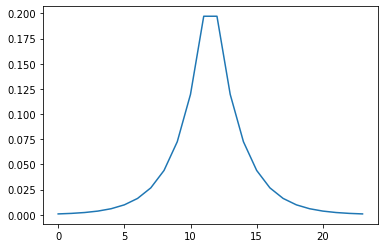

In [61]:
z=np.exp(-np.abs(np.arange(24,dtype=float)-11.5)/2+1e-3)
weights=z/np.sum(z)
print(z[11]/z[-1])
plt.plot(weights)

In [9]:
class ConvDeconvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvDeconvModel, self).__init__()
        #self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        
        surr = tf.keras.Sequential()
        surr.add(tf.keras.Input(shape=5))
        surr.add(tf.keras.layers.Dense(8, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(8, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(8, activation='leaky_relu'))
        surr.add(tf.keras.layers.BatchNormalization())
        surr.add(tf.keras.layers.Dense(16, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(16, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(16, activation='leaky_relu'))
        surr.add(tf.keras.layers.BatchNormalization())
        surr.add(tf.keras.layers.Dense(32, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(32, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(32, activation='leaky_relu'))
        
        #surr.build()
        #surr.summary()
        
        enc = tf.keras.Sequential()
        enc.add(tf.keras.layers.Reshape((24,48,1)))
        enc.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1),activation='leaky_relu', input_shape=(24,48,1),padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))  
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())

        enc.add(tf.keras.layers.Flatten())
        enc.add(tf.keras.layers.Dense(32,activation='leaky_relu'))

        #enc.build((None,24,48))
        #enc.summary()
        
        dec = tf.keras.Sequential()
        
        dec.add(tf.keras.layers.Dense(64*9,activation='leaky_relu'))
        dec.add(tf.keras.layers.Reshape((3,3,64)))

        dec.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', input_shape=(3,3,16), padding='same'))
        dec.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.BatchNormalization())
        dec.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        dec.add(tf.keras.layers.Reshape((24,48)))
        
        #dec.build((None,128))
        #dec.summary()
        
        self.sur = surr
        self.enc = enc
        self.dec = dec
        
    def call(self, inputs, training=False):
        if training:
            X,Y = inputs
            a = self.sur(X)
            b = self.enc(Y)
            c = self.dec(b)
            return a,b,c
        return self.dec(self.sur(inputs))

    
#    def compute_loss(self, x, y, y_pred, sample_weight):
#        a,b,c = y_pred
#        loss =  tf.reduce_mean(tf.math.squared_difference(c, y))
#        loss += tf.reduce_mean(tf.math.squared_difference(a, b))
#        return loss
    
        
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
        z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
        weights=z/kb.sum(z)
        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss


    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def build_graph(self, training=False):
        x = tf.keras.layers.Input(shape=(5))
        y = tf.keras.layers.Input(shape=(24,48))
        if training:
            return tf.keras.Model(inputs=[x,y], outputs=self.call([x,y], training=True))
        else:
            return tf.keras.Model(inputs=[x], outputs=self.call(x))


In [10]:
model=ConvDeconvModel()

In [11]:
model.build_graph(True).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 48)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           16310       input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           3632        input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
def loss_object(y, predictions):
    a,b,c = predictions
    z = tf.math.exp(-tf.math.abs(tf.range(24,dtype=float)-11.5)/2+1e-15)
    weights = tf.reshape(z,(1,-1,1))/tf.reduce_sum(z) * z.shape[0]
    loss_1 =  tf.reduce_mean(tf.math.squared_difference(c, y))
    #loss_1 =  tf.reduce_mean(tf.math.squared_difference(c, y))
    loss_2 = tf.reduce_mean(tf.math.squared_difference(a, b))
    return loss_1, loss_2

def loss_object_(y, predictions):
    a,b,c = predictions
    area_weight=dataset.area[0]
    area_weight_arr=area_weight.mean(dim="lon").values
    #plt.plot(area_weight_arr)
    area_weight_arr=tf.reshape(area_weight_arr,(1,-1,1))/tf.reduce_sum(area_weight_arr)
    area_weight_arr = tf.cast(area_weight_arr, 'float32')
    loss_1 =  tf.reduce_mean(tf.math.squared_difference(c, y) * area_weight_arr)
    loss_2 = tf.reduce_mean(tf.math.squared_difference(a, b))
    return loss_1, loss_2

def test_loss_object(y, predictions):
    z = tf.math.exp(-tf.math.abs(tf.range(24,dtype=float)-11.5)/2+1e-15)
    weights = (tf.reshape(z,(1,-1,1))/tf.reduce_sum(z)) * z.shape[0]
    return tf.reduce_mean(tf.math.squared_difference(predictions, y))
#    return tf.reduce_mean(tf.math.squared_difference(predictions, y))

def test_loss_object_(y, predictions):
    area_weight=dataset.area[0]
    area_weight_arr=area_weight.mean(dim="lon").values
    #plt.plot(area_weight_arr/np.sum(area_weight_arr))
    area_weight_arr=tf.reshape(area_weight_arr,(1,-1,1))/tf.reduce_sum(area_weight_arr)
    area_weight_arr = tf.cast(area_weight_arr, 'float32')
    return tf.reduce_mean(tf.math.squared_difference(predictions, y) * area_weight_arr)
    


train_loss = tf.keras.metrics.Mean(name='train_loss')

test_loss = tf.keras.metrics.Mean(name='test_loss')

encoder_loss = tf.keras.metrics.Mean(name='encoder_loss')

predictor_loss = tf.keras.metrics.Mean(name='predictor_loss')

train_2_loss = tf.keras.metrics.Mean(name='train_loss')

In [22]:
EPOCHS_1 = 100
EPOCHS_2 = 100
BATCH_SIZE = 256
lr1 = 1e-4
lr_rate1 = .99
lr2 = 5e-3
lr_rate2 = .99

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, Y_train)).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)

lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1,decay_steps=1000,decay_rate=lr_rate1)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [34]:
@tf.function
def train_step(X_train, Y_train):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model((X_train,Y_train), training=True)
        loss_1, loss_2 = loss_object(labels, predictions)
        loss = loss_1 + loss_2
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    encoder_loss(loss_1)
    predictor_loss(loss_2)
    
    
@tf.function
def test_step(X_test, Y_test):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(X_test, training=False)
    t_loss = test_loss_object(Y_test, predictions)

    test_loss(t_loss)

In [35]:
history = []
for epoch in range(EPOCHS_1):
    # Reset the metrics at the start of the next epoch
    encoder_loss.reset_states()
    predictor_loss.reset_states()
    train_loss.reset_states()
    test_loss.reset_states()

    for x, labels in train_ds:
        train_step(x, labels)

    for x_test, test_labels in test_ds:
        test_step(x_test, test_labels)

    history.append([train_loss.result().numpy(), test_loss.result().numpy(), encoder_loss.result().numpy(), predictor_loss.result().numpy()])
    #print(
    #f'Epoch {epoch + 1}, '
    #f'L: {train_loss.result()}, '
    #f'Test L: {test_loss.result()}, ',
    #f'Enc L: {encoder_loss.result()}, '
    #f'Pred L: {predictor_loss.result()}, '
    #)
history = np.array(history)

In [36]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, Y_train)).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)

lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr2,decay_steps=1000,decay_rate=lr_rate2)
optimizer = tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.keras.optimizers.Adam(lr2)

In [37]:
@tf.function
def train_2_step(X_train, Y_train):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(X_train, training=False)
        loss = test_loss_object(Y_train, predictions)
    gradients = tape.gradient(loss,  model.sur.trainable_variables)
    optimizer.apply_gradients(zip(gradients,  model.sur.trainable_variables + model.dec.trainable_variables))

    train_2_loss(loss)

In [38]:
history_2 = []
for epoch in range(EPOCHS_2):
    # Reset the metrics at the start of the next epoch
    train_2_loss.reset_states()
    test_loss.reset_states()

    for x, labels in train_ds:
        train_2_step(x, labels)

    for x_test, test_labels in test_ds:
        test_step(x_test, test_labels)

    history_2.append([train_2_loss.result().numpy(), test_loss.result().numpy()])
    #print(
    #f'Epoch {epoch + 1}, '
    #f'Lodss: {train_2_loss.result()}, '
    #f'Test Loss: {test_loss.result()}, '
    #)
history_2 = np.array(history_2)

In [211]:
test_loss.reset_states()
for x_test, test_labels in test_ds:
    test_step(x_test, test_labels)
print(test_loss.result().numpy())

0.00044618937


In [110]:
Y_pred = model(x_test)
mse_test=np.mean(np.square(Y_pred-Y_test))
mse_test

0.028326802

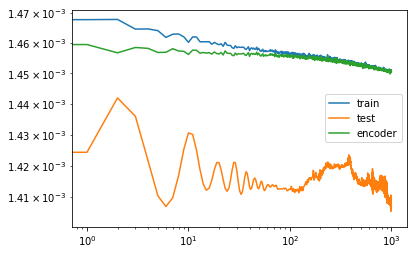

In [213]:
plt.loglog(history[:,:3])
plt.legend(['train', 'test', 'encoder', 'predictor'])

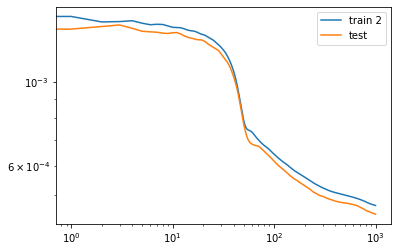

In [214]:
plt.loglog(history_2)
plt.legend(['train 2', 'test'])

/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/clif/visualization/contour.py:260: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(self.cplt_, cax=cbax, drawedges=True, alpha=0.5)


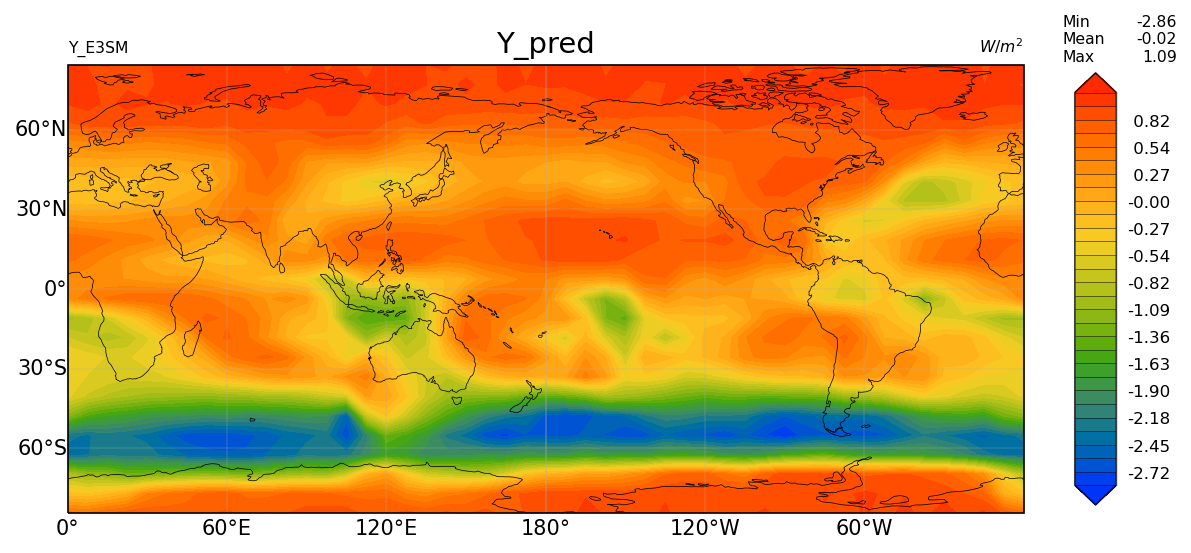

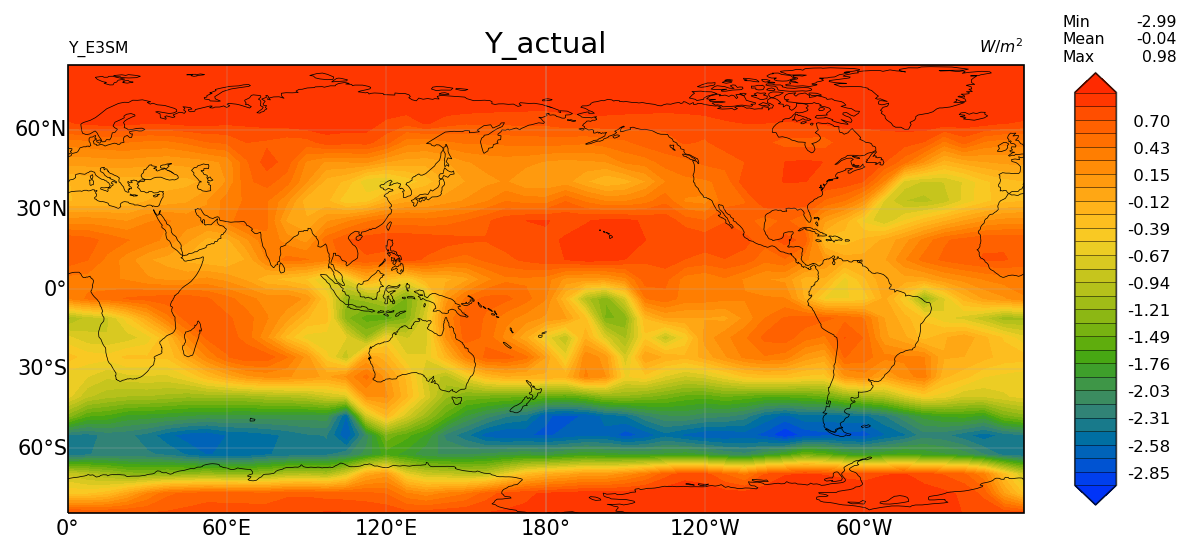

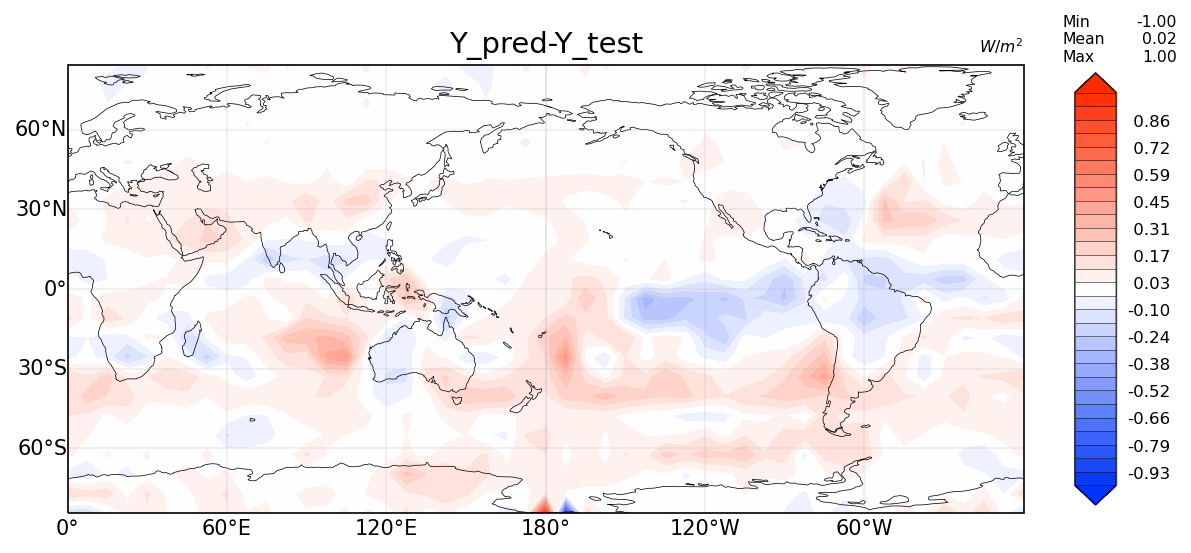

In [227]:
plot(Y_pred,Y_test,-1)